#Mount Drive

Connecting local drive with google collab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Requirement file on drive

In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
#CFG file location on drive
!ls /mydrive/GitlabProject/FaceMaskDetection

256-32_yolov2_resnet50.cfg


#YOLOv2

Import Darknet Repository from AlexeyAB

In [57]:
import os
# clone darknet repo (AlexeyAB)
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


Change OpenCV, GPU, CUDNN to 1 on Makefile

In [58]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [59]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
# make darknet (build)
!make

Get YOLOv2 weight from pjreddie

In [61]:
! wget https://pjreddie.com/media/files/yolov2.weights

--2023-08-08 14:57:11--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights.1’

yolov2.weights.1    100%[===================>] 194.49M  61.0MB/s    in 3.4s    

2023-08-08 14:57:15 (56.8 MB/s) - ‘yolov2.weights.1’ saved [203934260/203934260]



# Load Dataset

**Import Kaggle Dataset**

In [ ]:
#Get kaggle.json from drive download link for import dataset directly into the reppo
%cd content
!wget -O kaggle.json https://drive.google.com/u/4/uc?id=1D0t9YFC4sJdQMTYWnTdg79cj7HgMk3gk&export=download

In [14]:
! chmod 600 /content/kaggle.json

**Download and Extract Dataset**

In [15]:
#Two different Facemask dataset
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d andrewmvd/face-mask-detection
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d shreyashwaghe/medical-mask-dataset

 98% 389M/398M [00:02<00:00, 153MB/s]
100% 398M/398M [00:02<00:00, 149MB/s]
 81% 117M/144M [00:01<00:00, 115MB/s]
100% 144M/144M [00:01<00:00, 126MB/s]


In [16]:
import zipfile
#Extract FaceMask Dataset
zip_file = zipfile.ZipFile('/content/face-mask-detection.zip', 'r')
zip_file.extractall('/dataset/facemask/')

#Extract MedicalMask Dataset
zip_file = zipfile.ZipFile('/content/medical-mask-dataset.zip', 'r')
zip_file.extractall('/dataset/medicalmask/')


**Converting XML label from FaceMask Dataset to txt yolo label**

In [19]:
#Add convert code to make yolo label
!cp -r /mydrive/GitlabProject/FaceMaskDetection/convert.py /dataset/facemask/annotations/convert.py

In [20]:
%cd /dataset/facemask/annotations
!python convert.py

/dataset/facemask/annotations


Delete xml file that unused

In [21]:
#Delete all xml file
import os
import glob
for file in glob.glob("*.xml"):
  os.remove(file)
os.remove('convert.py')

**Merge Dataset**

In [22]:
import shutil
shutil.copytree('/dataset/medicalmask/Dataset/Medical_Masks_Dataset/images', '/dataset/facemask/images',dirs_exist_ok=True)
shutil.copytree('/dataset/medicalmask/Dataset/Medical_Masks_Dataset/yolo_labels', '/dataset/facemask/annotations',dirs_exist_ok=True)

'/dataset/facemask/annotations'

# Data Split


Split dataset in 3 different type: train, validation (val), test with pip library

In [23]:
!pip install split-folders

In [24]:
import splitfolders
splitfolders.ratio('/dataset/facemask/', output='/dataset/merge/', seed=42, ratio = (.7,.2,.1), group_prefix = None)

Copying files: 3046 files [00:01, 1899.75 files/s]


#Data Augmentation

Creating a new base data facemask, with a difference on  Image Position, Brightness, Contrast, Blur, Hue, Saturation

In [28]:
#Train Data Augmentation
shutil.copytree('/dataset/merge/train/', '/dataset/facemask2/',dirs_exist_ok=True)

'/dataset/facemask2/'

In [29]:
def normalize (file):
  class_label = []
  bboxes_yolo = []
  nAnnotations = []
  with open(file, 'r') as fr:
      lines = fr.readlines()
      with open(file, 'r') as fw:
          for line in lines:
            space = 0
            nAnnotations = []
            text = ''
            for a in line:
              if space == 0 and a != ' ':
                class_label.append(int(a))
              else:
                text = text + a
              if a == ' ' or a == '\n':
                space +=1
                if space > 1:
                  nAnnotations.append(float(text))
                  text = ''
            bboxes_yolo.append(nAnnotations)
  return bboxes_yolo, class_label


def mergeClassBboxes(labelPath, class_labels, transformed_bboxes):
  c = list(zip(class_labels,transformed_bboxes))
  with open(labelPath, 'w') as fw:
    for elem in c:
      fw.write(str(elem[0]) + " " + str(elem[1]) +"\n")
  with open(labelPath, 'r') as fr:
      lines = fr.readlines()
      with open(labelPath, 'w') as fw:
          for line in lines:
            for a in line:
              if a != '(' and a != ',' and a != ')':
                fw.write(str(a))



In [30]:
def augmentation(bboxes_yolo, class_labels, imageFile):
  import cv2
  import albumentations as A
  import numpy

  image = cv2.imread(imageFile)
  transform = A.Compose([
          A.HorizontalFlip(p=1),
          A.RandomBrightnessContrast(p=0.5),
          A.Blur(blur_limit=7, p=0.3),
          A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.3)
      ], bbox_params=A.BboxParams(
          format='yolo', label_fields=['class_labels']
      ))

  transformed_instance = transform(
      image=image, bboxes=bboxes_yolo, class_labels=class_labels
  )

  transformed_image = transformed_instance['image']
  transformed_bboxes = transformed_instance['bboxes']
  transformed_class_labels = transformed_instance['class_labels']
  return transformed_image, transformed_bboxes

In [31]:
from imutils import paths
import cv2
import numpy as np

# !cp /content/gdrive/MyDrive/TA/bbox_utils.py /usr/local/lib/python3.8/dist-packages/albumentations/core/bbox_utils.py

imagePaths = list(paths.list_images("/dataset/facemask2/images/"))
labelPaths = list(paths.list_files("/dataset/facemask2/annotations/"))
imagePaths.sort()
labelPaths.sort()
for (image, label) in zip(imagePaths, labelPaths):
  try:
    bboxes_yolo, class_labels = normalize(label)
    transformed_image,transformed_bboxes  = augmentation(bboxes_yolo,class_labels,image )
    cv2.imwrite(image,transformed_image)
    mergeClassBboxes(label, class_labels, transformed_bboxes)
  except:
    print(image, 'Not augmented')

/dataset/facemask2/images/maksssksksss260.png Not augmented
/dataset/facemask2/images/maksssksksss509.png Not augmented
/dataset/facemask2/images/maksssksksss518.png Not augmented
/dataset/facemask2/images/maksssksksss603.png Not augmented
/dataset/facemask2/images/maksssksksss723.png Not augmented


In [32]:
imagePaths = list(paths.list_images("/dataset/facemask2/images/"))
labelPaths = list(paths.list_files("/dataset/facemask2/annotations/"))
imagePaths.sort()
labelPaths.sort()
i = 0
for (image, label) in zip(imagePaths, labelPaths):
  i = i + 1
  shutil.move(image, '/dataset/merge/train/images/flip'+ str(i) +'.png')
  shutil.move(label, '/dataset/merge/train/annotations/flip'+ str(i) +'.txt')

Resized image (not necessary)

In [33]:
# %cd /dataset/facemask/images/
# import cv2
# for file in glob.glob("*"):
#   img_rgb = cv2.imread(file)
#   img_resized = cv2.resize(img_rgb, (224, 224))
#   cv2.imwrite(file,img_resized)

**Merge Annotations and Images and Move To Darknet Repository**

In [34]:
#Merge Label and Images
shutil.copytree("/dataset/merge/test/annotations", "/dataset/merge/test/images", dirs_exist_ok=True)
shutil.copytree("/dataset/merge/train/annotations", "/dataset/merge/train/images", dirs_exist_ok=True)
shutil.copytree("/dataset/merge/val/annotations", "/dataset/merge/val/images", dirs_exist_ok=True)

#Go to Darknet File
shutil.copytree("/dataset/merge/test/images", "/content/darknet/data/test", dirs_exist_ok=True)
shutil.copytree("/dataset/merge/train/images", "/content/darknet/data/train", dirs_exist_ok=True)
shutil.copytree("/dataset/merge/val/images", "/content/darknet/data/val", dirs_exist_ok=True)


'/content/darknet/data/val'

##Function to show prediction result

In [26]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

#Test Yolov2 Trained Model COCO

In [25]:
%cd  /content/darknet
!./darknet detector test cfg/coco.data cfg/yolov2.cfg yolov2.weights '/content/darknet/data/dog.jpg'

/content/darknet
 CUDA-version: 11080 (12000), cuDNN: 8.9.0, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 max                2x 2/ 2    416 x 416 x  32 ->  208 x 208 x  32 0.006 BF
   2 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   3 max                2x 2/ 2    208 x 208 x  64 ->  104 x 104 x  64 0.003 BF
   4 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   5 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   6 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   7 max                2x 2/ 2    104 x 104 x 128 ->   52 x  52 x 128 0.001 BF
   

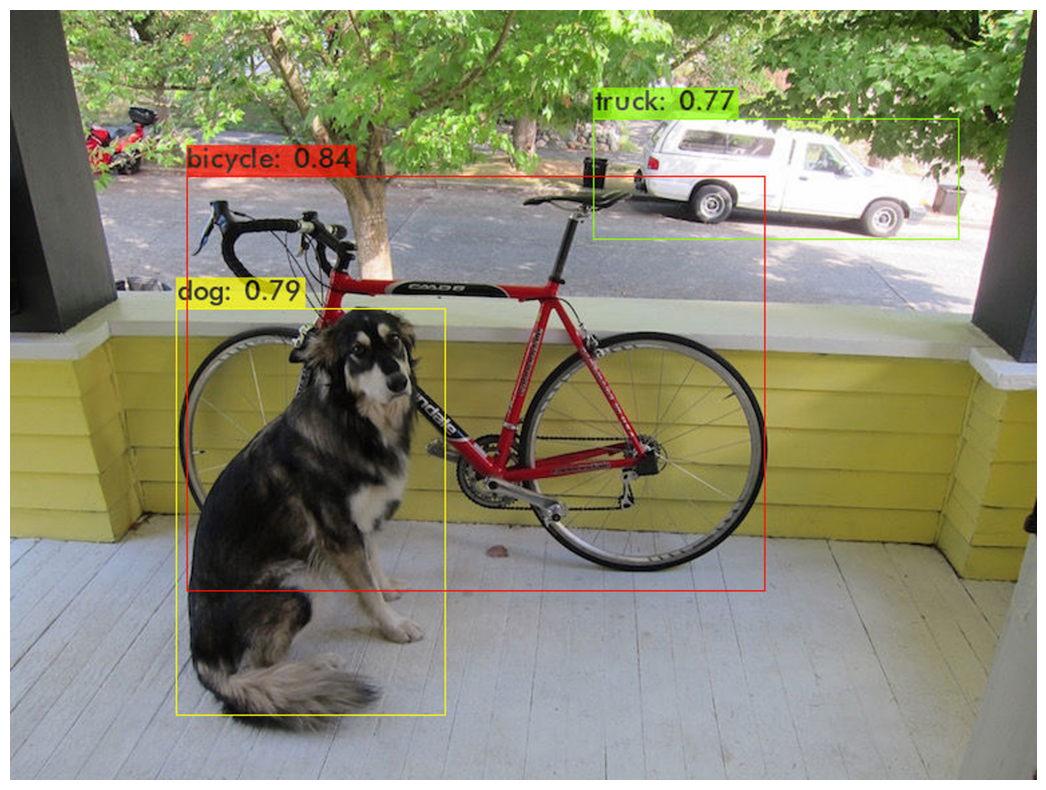

In [27]:
imShow('predictions.jpg')

#Training Preparation

**Drive Get .data .names and .cfg Files**

You need to create obj.data (location dataset and result) and obj.names (add name for classification) as in the repository


In [38]:
%cd ..
!cp /content/gdrive/MyDrive/GitlabProject/FaceMaskDetection/256-32_yolov2_resnet50.cfg /content/darknet/256-32_yolov2_resnet50.cfg
!cp /content/gdrive/MyDrive/GitlabProject/FaceMaskDetection/obj.data /content/darknet/obj.data
!cp /content/gdrive/MyDrive/GitlabProject/FaceMaskDetection/obj.names /content/darknet/obj.names



/


Convert file .cfg and obj from DOS tu UNIX

In [39]:
%cd /content/
! wget  https://files.pythonhosted.org/packages/e2/c3/92ba0ecdd6ab252f2eca753b5fad10d1454237e357f5ec8f3cc798d70980/dos2unix-1.zip

/content
--2023-08-08 14:41:15--  https://files.pythonhosted.org/packages/e2/c3/92ba0ecdd6ab252f2eca753b5fad10d1454237e357f5ec8f3cc798d70980/dos2unix-1.zip
Resolving files.pythonhosted.org (files.pythonhosted.org)... 151.101.1.55, 151.101.65.55, 151.101.129.55, ...
Connecting to files.pythonhosted.org (files.pythonhosted.org)|151.101.1.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992 [application/octet-stream]
Saving to: ‘dos2unix-1.zip’

dos2unix-1.zip      100%[===================>]     992  --.-KB/s    in 0s      

2023-08-08 14:41:15 (53.6 MB/s) - ‘dos2unix-1.zip’ saved [992/992]



In [40]:
import zipfile
zip_file = zipfile.ZipFile('/content/dos2unix-1.zip', 'r')
zip_file.extractall('/content/darknet/dosunix')

In [41]:
!python  /content/darknet/dosunix/dos2unix.py /content/darknet/obj.names /content/darknet/obj.names
!python  /content/darknet/dosunix/dos2unix.py /content/darknet/obj.data  /content/darknet/obj.data

Done. Stripped 1 bytes.
Done. Stripped 3 bytes.


In [42]:
# %cd ..
# !cp /content/darknet/obj.data  /mydrive/TA/Backup
# JUST TEST TO MYDRIVE

**List Image Paths to .txt**

In [43]:
from imutils import paths
import cv2
%cd /content/darknet

/content/darknet


In [44]:
imagePaths = list(paths.list_images("/content/darknet/data/train"))
with open("train.txt", 'w') as file:
        for row in imagePaths:
            s = "".join(map(str, row))
            file.write(s+'\n')

In [45]:
imagePaths = list(paths.list_images("/content/darknet/data/val"))
with open("valid.txt", 'w') as file:
        for row in imagePaths:
            s = "".join(map(str, row))
            file.write(s+'\n')

In [46]:
imagePaths = list(paths.list_images("/content/darknet/data/test"))
with open("test.txt", 'w') as file:
        for row in imagePaths:
            s = "".join(map(str, row))
            file.write(s+'\n')

In [47]:
!python  /content/darknet/dosunix/dos2unix.py /content/darknet/train.txt  /content/darknet/train.txt
!python  /content/darknet/dosunix/dos2unix.py /content/darknet/valid.txt  /content/darknet/valid.txt
!python  /content/darknet/dosunix/dos2unix.py /content/darknet/test.txt  /content/darknet/test.txt

Done. Stripped 0 bytes.
Done. Stripped 0 bytes.
Done. Stripped 0 bytes.


**Pre-trained**

In [48]:
# upload pretrained convolutional layer weights
%cd /content/darknet
!wget http://pjreddie.com/media/files/darknet19_448.conv.23
!wget http://pjreddie.com/media/files/darknet53.conv.74

/content/darknet
URL transformed to HTTPS due to an HSTS policy
--2023-08-08 14:41:16--  https://pjreddie.com/media/files/darknet19_448.conv.23
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79327120 (76M) [application/octet-stream]
Saving to: ‘darknet19_448.conv.23’

darknet19_448.conv. 100%[===================>]  75.65M  49.3MB/s    in 1.5s    

2023-08-08 14:41:18 (49.3 MB/s) - ‘darknet19_448.conv.23’ saved [79327120/79327120]

URL transformed to HTTPS due to an HSTS policy
--2023-08-08 14:41:18--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[==================

In [49]:
!wget https://pjreddie.com/media/files/resnet50.weights

--2023-08-08 14:41:21--  https://pjreddie.com/media/files/resnet50.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91303604 (87M) [application/octet-stream]
Saving to: ‘resnet50.weights’

resnet50.weights    100%[===================>]  87.07M  52.3MB/s    in 1.7s    

2023-08-08 14:41:23 (52.3 MB/s) - ‘resnet50.weights’ saved [91303604/91303604]



#Yolo2 and Resnet50

In [ ]:
%cd /content/darknet
!./darknet detector train obj.data 256-32_yolov2_resnet50.cfg resnet50.weights -clear -dont_show

In [ ]:
#optional if error at test, you can edit parser.c file
!cp /content/gdrive/MyDrive/GitlabProject/FaceMaskDetection/parser.c /content/darknet/src/parser.c
#You have to compile YOLOv2 again at top (Second Section)

In [63]:
#You need to check to /content/darknet/data/test of exist image
%cd /content/darknet
! ./darknet detector test obj.data 256-32_yolov2_resnet50.cfg /mydrive/GitlabProject/FaceMaskDetection/256-32_yolov2_resnet50_last.weights '/content/darknet/data/test/110.jpg' -iou_thresh 0.6
imShow('predictions.jpg')

/content/darknet
 CUDA-version: 11080 (12000), cuDNN: 8.9.0, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     64       7 x 7/ 2    416 x 416 x   3 ->  208 x 208 x  64 0.814 BF
   1 max                2x 2/ 2    208 x 208 x  64 ->  104 x 104 x  64 0.003 BF
   2 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   3 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   4 conv    256       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x 256 0.354 BF
   5 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 104 x 104 x 256 0.003 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 256 ->  104 x 104 x  64 0.354 BF
   7 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   8 co

**Mapping result of training, mAP, Precision, Recall**

In [65]:
! ./darknet detector map obj.data 256-32_yolov2_resnet50.cfg /mydrive/GitlabProject/FaceMaskDetection/256-32_yolov2_resnet50_last.weights

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     64       7 x 7/ 2    416 x 416 x   3 ->  208 x 208 x  64 0.814 BF
   1 max                2x 2/ 2    208 x 208 x  64 ->  104 x 104 x  64 0.003 BF
   2 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   3 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   4 conv    256       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x 256 0.354 BF
   5 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 104 x 104 x 256 0.003 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 256 ->  104 x 104 x  64 0.354 BF
   7 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   8 conv    256       1